In [1]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegFileWriter
from IPython.display import HTML
import numpy as np
from itertools import product
import pandas as pd
import os
import rasterio.warp as rasteriowarp

In [2]:
SATELLITE_DATA_PATH = '/storage/data/eumetsat/native/reprojected2/'
PV_DATA_FILENAME = '~/data/pvoutput.org/UK_PV_timeseries_batch.nc'
PV_METADATA_FILENAME = '~/data/pvoutput.org/UK_PV_metadata.csv'

DST_CRS = {
    'ellps': 'WGS84',
    'proj': 'tmerc',  # Transverse Mercator
    'units': 'm'}  # meters


# Geographical boundary in meters (Transverse Mercator projection)
SOUTH = 5513500
NORTH = 6613500

# For UK
UK_WEST =  -889500
UK_EAST =   410500

def get_16_9_west_east():
    """Helper function to get west and east coordinates (Transverse Mercator) for a 16:9 aspect-ratio video."""
    height = NORTH - SOUTH
    width = height * (16/9)
    half_width = width / 2
    centre_y = np.mean((UK_WEST, UK_EAST))
    west = centre_y - half_width
    east = centre_y + half_width
    return int(np.floor(west)), int(np.floor(east)) + 3000

# For 16:9:
WEST, EAST = get_16_9_west_east()

WEST, EAST

(-1217278, 741277)

## Load and convert PV metadata

In [3]:
pv_metadata = pd.read_csv(PV_METADATA_FILENAME, index_col='system_id')
pv_metadata.dropna(subset=['longitude', 'latitude'], how='any', inplace=True)

In [4]:
# Convert lat lons to Transverse Mercator
pv_metadata['x'], pv_metadata['y'] = rasteriowarp.transform(
    src_crs={'init': 'EPSG:4326'},
    dst_crs=DST_CRS,
    xs=pv_metadata['longitude'].values,
    ys=pv_metadata['latitude'].values)

# Filter 3 PV systems which apparently aren't in the UK!
pv_metadata = pv_metadata[
    (pv_metadata.x >= WEST) &
    (pv_metadata.x <= EAST) &
    (pv_metadata.y <= NORTH) &
    (pv_metadata.y >= SOUTH)]

len(pv_metadata)

2548

## Load and normalise PV power data

In [51]:
%%time
pv_power = xr.load_dataset(PV_DATA_FILENAME)

CPU times: user 13.8 s, sys: 930 ms, total: 14.7 s
Wall time: 14.7 s


In [52]:
pv_power_selected = pv_power.loc[dict(datetime=slice('2019-06-20', '2019-06-30'))]

In [53]:
pv_power_df = pv_power_selected.to_dataframe().dropna(axis='columns', how='all')
pv_power_df = pv_power_df.clip(lower=0, upper=5E7)
pv_power_df.columns = [np.int64(col) for col in pv_power_df.columns]

In [54]:
pv_power_df = pv_power_df.tz_localize('Europe/London').tz_convert('UTC')

In [55]:
# A bit of hand-crafted cleaning
pv_power_df[30248][:'2019-01-03'] = np.NaN

In [56]:
# Normalise
pv_power_df -= pv_power_df.min()
pv_power_df /= pv_power_df.max()

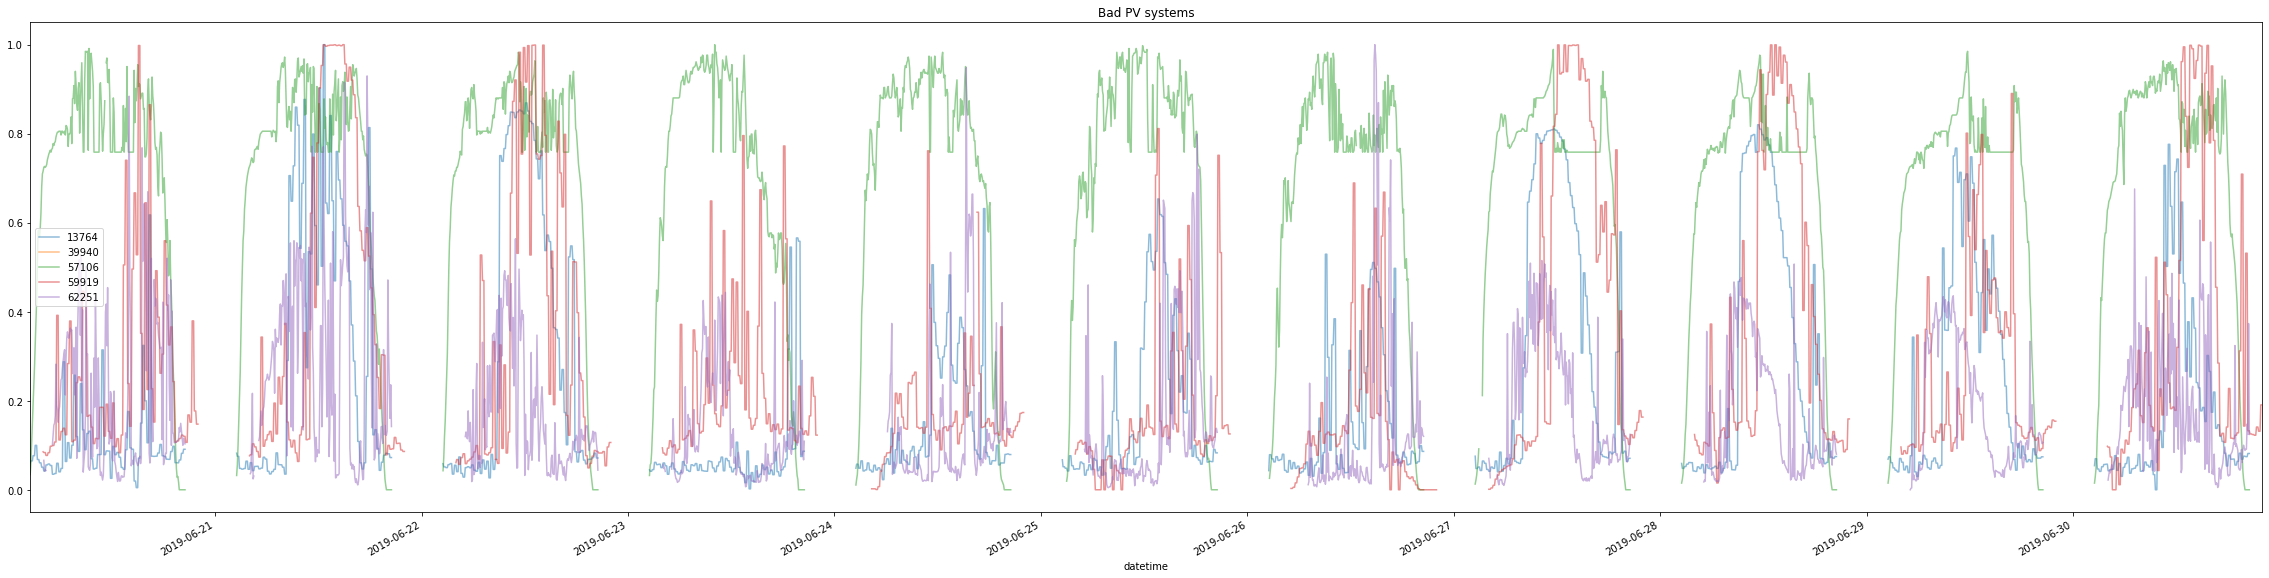

In [60]:
# Drop systems which are producing over night
NIGHT_YIELD_THRESHOLD = 0.4
night_hours = list(range(20, 24)) + list(range(0, 4))
bad_systems = np.where(
    (pv_power_df[pv_power_df.index.hour.isin(night_hours)] > NIGHT_YIELD_THRESHOLD).sum())[0]
bad_systems = pv_power_df.columns[bad_systems]
ax = pv_power_df[bad_systems].plot(figsize=(40, 10), alpha=0.5)
ax.set_title('Bad PV systems');

In [61]:
pv_power_df.drop(bad_systems, axis='columns', inplace=True)

In [62]:
# Interpolate
pv_power_df = pv_power_df.interpolate(limit=3)

In [63]:
len(pv_power_df.columns)

789

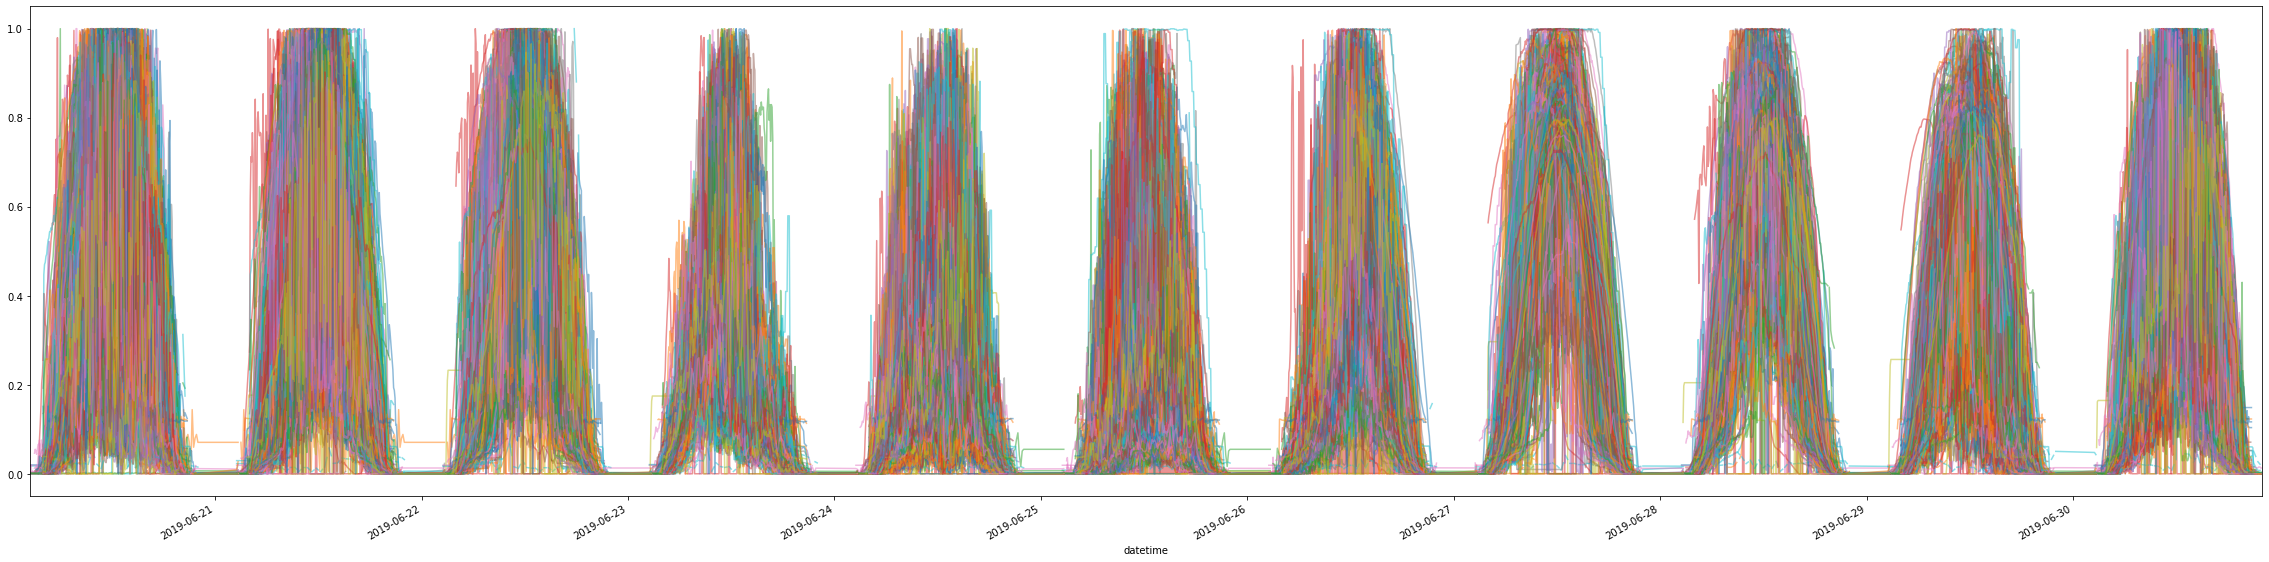

In [64]:
pv_power_df.plot(figsize=(40, 10), alpha=0.5, legend=False);

In [65]:
# Sort the metadata
pv_metadata = pv_metadata.reindex(pv_power_df.columns, axis='index')

## Load satellite data

In [16]:
DAYS = range(20, 31)
HOURS = range(3, 21)
satellite_data_filenames = [
    os.path.join(SATELLITE_DATA_PATH, '2019-06-{:02d}T{:02d}.nc'.format(day, hour))
    for day, hour in list(product(DAYS, HOURS))]

In [17]:
%%time
dataset = xr.open_mfdataset(paths=satellite_data_filenames, concat_dim='time')
da = dataset['HRV']

CPU times: user 1.63 s, sys: 130 ms, total: 1.76 s
Wall time: 6.82 s


/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue 

In [18]:
data_region_of_interest = da.loc[dict(x=slice(WEST, EAST), y=slice(NORTH, SOUTH))]

def get_satellite_data(i=0):
    data = data_region_of_interest[i]

    # Normalise using a rolling maximum
    start_i = max(i-4, 0)
    rolling_max = data_region_of_interest[start_i:i+4].max(dim=['x', 'y']).mean()
    data /= rolling_max
    return data

In [66]:
CMAP = cm.get_cmap('plasma')
def get_colors(dt):
    colors = pv_power_df.loc[dt]
    colors = np.ma.masked_array(colors, mask=colors.isna())
    return CMAP(colors)

In [67]:
import matplotlib.patches as patches
def draw_rectangle(ax, centre_x, centre_y, width, height):
    # Calculate left & bottom coordinates
    left = centre_x - (width / 2)
    bottom = centre_y - (height / 2)
    
    # Create rectange
    rectangle = patches.Rectangle(
        xy=(left, bottom),
        width=width,
        height=height,
        linewidth=1,
        edgecolor='r',
        facecolor='none')
    
    ax.add_patch(rectangle)
    return rectangle

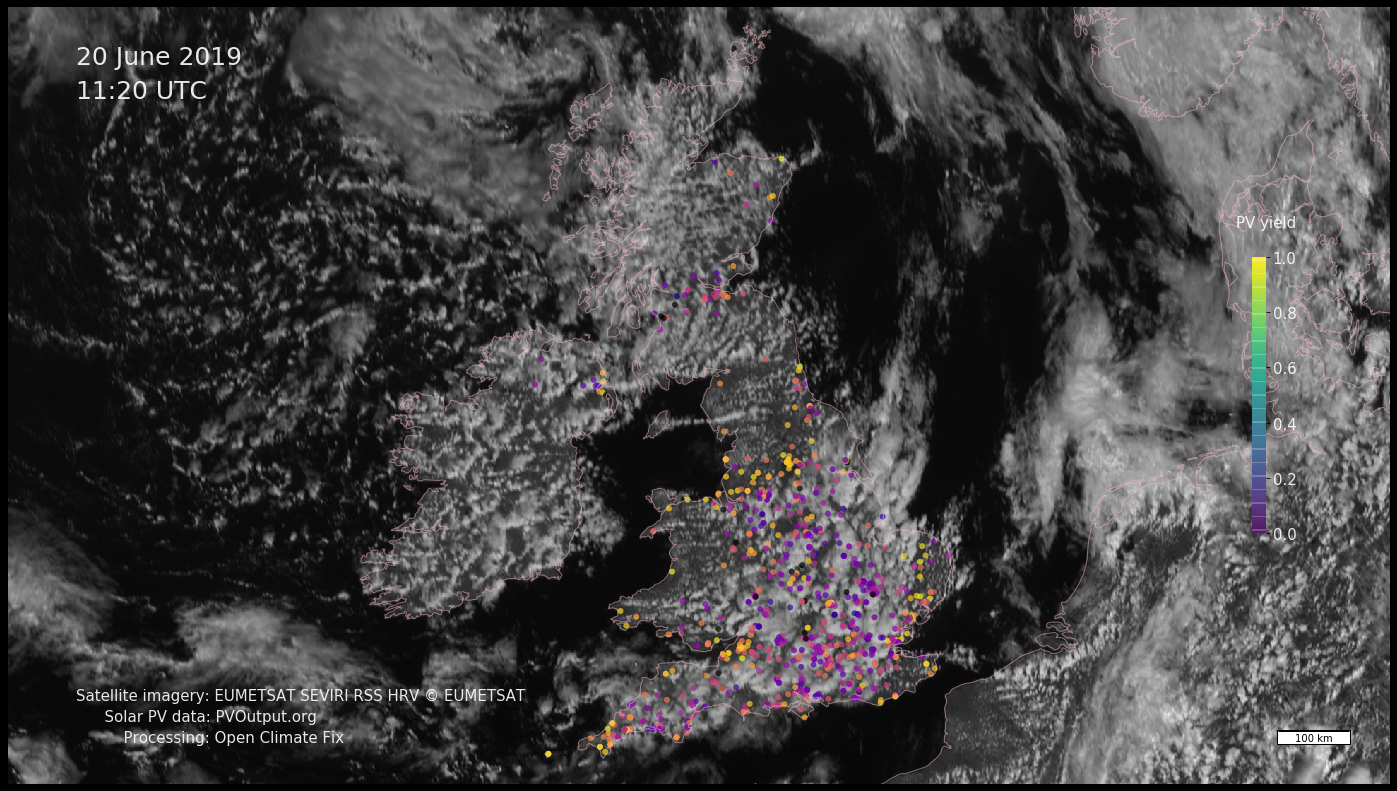

In [69]:
TEXT_CONFIG = {'alpha': 0.9, 'linespacing': 1.5}
DATE_FORMAT = '%d %B %Y\n%H:%M UTC'

fig = plt.figure(figsize=(19.20, 10.80))  # moviewriter doesn't listen to the width, just the height
fig.patch.set_facecolor('black')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
crs = ccrs.TransverseMercator()
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', alpha=0.5, color='pink')

sat_data = get_satellite_data(1350)
img = sat_data.plot.imshow(ax=ax, cmap='gray', origin='upper', vmin=0.02, vmax=1, add_colorbar=False)
path_collection = ax.scatter(x=pv_metadata.x, y=pv_metadata.y, alpha=0.7, linewidth=0)
ax.set_title(None)

# Info text at bottom of figure
ax.text(
    x=0.05, 
    y=0.05, 
    s=(
        'Satellite imagery: EUMETSAT SEVIRI RSS HRV © EUMETSAT\n'
        '      Solar PV data: PVOutput.org\n'
        '          Processing: Open Climate Fix'),
    color='white', fontsize=15, transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='left', **TEXT_CONFIG)

# Colorbar for PV yield
colorbar = fig.colorbar(path_collection, ax=ax, drawedges=False, fraction=0.01, pad=-0.1)
colorbar.set_label('PV yield', color='white', fontsize=15, rotation=0, y=1.15, labelpad=-30, **TEXT_CONFIG)
colorbar.outline.set_color('none')
colorbar_yticklabels = plt.getp(colorbar.ax.axes, 'yticklabels')
plt.setp(colorbar_yticklabels, color='white', fontsize=15, **TEXT_CONFIG)

# Datetime text
dt = pd.Timestamp(sat_data.time.values, tz='UTC')
datetime_text = ax.text(
    x=0.05, y=0.95, 
    s=dt.strftime(DATE_FORMAT), 
    color='white', fontsize=25, transform=ax.transAxes, 
    verticalalignment='top', horizontalalignment='left', **TEXT_CONFIG)

# Scale bar
scalebar = AnchoredSizeBar(
    transform=ax.transData,
    size=100000,
    label='100 km',
    loc=4,  # 4: lower right
    borderpad=4)
ax.add_artist(scalebar)

#draw_rectangle(
#    ax=ax, 
#    centre_x=pv_metadata.iloc[1].x,
#    centre_y=pv_metadata.iloc[1].y,
#    width=128000,
#    height=128000)

def update(i):
    sat_data = get_satellite_data(i)
    img.set_data(sat_data)
    dt = pd.Timestamp(sat_data.time.values, tz='UTC')
    try:
        colors = get_colors(dt)
    except KeyError:
        colors = np.zeros((len(pv_metadata), 4))
    path_collection.set_color(colors)
    datetime_text.set_text(dt.strftime(DATE_FORMAT))

update(100)

In [ ]:
# Docs: https://matplotlib.org/3.1.1/api/animation_api.html#writer-classes
metadata = dict(title='UK solar PV yield and clouds in June 2019', artist='Open Climate Fix')
moviewriter = FFMpegFileWriter(fps=12, bitrate=100000, metadata=metadata)

with moviewriter.saving(fig, 'UK_PV_and_clouds_June2019_tz_corrected.mp4', dpi=100):
    for i in np.arange(da.time.size):
        update(i)
        moviewriter.grab_frame(bbox_inches='tight', pad_inches=0, facecolor='black')